In [1]:
%pylab inline
import collections
import math
import boto3
import torch
import os, tarfile, json
import time, datetime
import subprocess
from io import StringIO
import numpy as np
import pandas as pd
import sagemaker
from matplotlib import patches
from PIL import Image
from tqdm import tqdm 
from glob import glob
from sagemaker.pytorch import estimator, PyTorchModel, PyTorchPredictor, PyTorch
from sagemaker.utils import name_from_base
from types import SimpleNamespace

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'privisaa-bucket-2' #sagemaker_session.default_bucket() # can replace with your own S3 bucket 'privisaa-bucket-virginia' # 
prefix = 'detectron2'
runtime_client = boto3.client('runtime.sagemaker')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Grab our data
!wget https://motchallenge.net/data/MOT20.zip -O /tmp/MOT20.zip

In [ ]:
# unzip our data
!unzip -q /tmp/MOT20.zip -d ~/SageMaker/MOT20
!rm /tmp/MOT20.zip

In [ ]:
# send our data to s3
!aws s3 cp --recursive ~/SageMaker/MOT20 s3://{bucket}/ --quiet

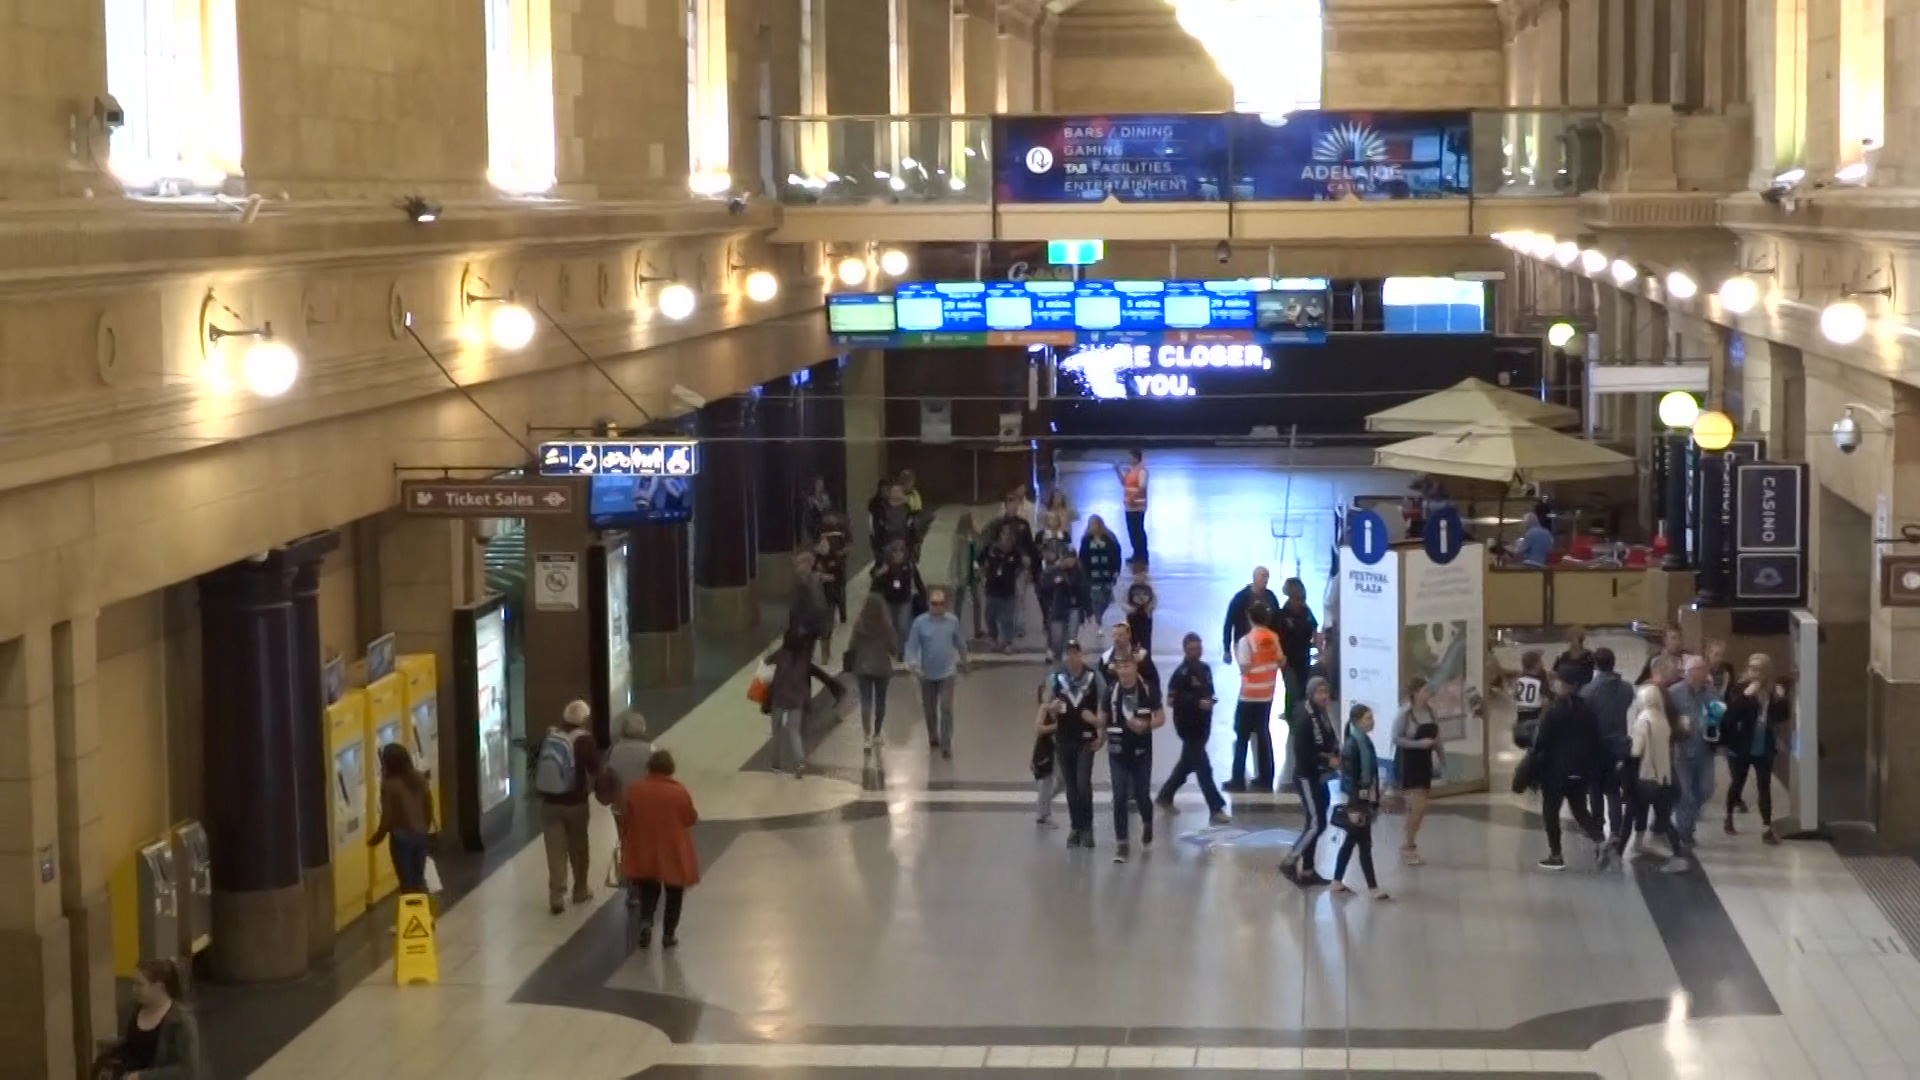

In [2]:
# Let's plot an image from MOT20

img_paths = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/img1/*.jpg')
img_paths.sort()

# grab our labels
labels = []
with open('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/gt/gt.txt', 'r') as f:
    for line in f:
        labels.append(line.replace('\n','').split(','))

imgs = []
for imgp in img_paths:
    img = Image.open(imgp)
    imgs.append(img)
img

In [6]:
# get our image paths 
img_path_dict = {}
img_paths = []
folders = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/*')
for fold in folders:
    img_path = glob(f"/home/ec2-user/SageMaker/MOT20/MOT20/train/{fold.split('/')[-1]}/img1/*")
    img_path.sort()
    img_paths.extend(img_path)
    img_path_dict[fold.split('/')[-1]] = img_path
    
# grab our label paths
lab_txt_dict = {}
# label_paths = []
for fold in folders:
    lab_path = glob(f"/home/ec2-user/SageMaker/MOT20/MOT20/train/{fold.split('/')[-1]}/gt/*")
#     label_paths.extend(lab_path)
#     lab_path_dict[fold.split('/')[-1]] = lab_path
    labels = []
    with open(lab_path[0], 'r') as f:
        for line in f:
            labels.append(line.replace('\n','').split(','))
    lab_dict = {}

    # creating label dictionary starting from 1 
    for i in range(1,len(img_path_dict[fold.split('/')[-1]])+1):
        lab_dict[i] = []

    # append entries based on the frame id
    for lab in labels:
        lab_dict[int(lab[0])].append(lab)
        
    lab_txt_dict[fold.split('/')[-1]] = lab_dict

    
# open one label file
labels = []
with open('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/gt/gt.txt', 'r') as f:
    for line in f:
        labels.append(line.replace('\n','').split(','))
        
# in the label files it's organized 
    
len(img_paths)


8931

In [7]:
# put our labels in a frame level dictionary

lab_dict = {}

# creating label dictionary starting from 1 
for i in range(1,len(img_paths)+1):
    lab_dict[i] = []
    
# append entries based on the frame id
for lab in labels:
    lab_dict[int(lab[0])].append(lab)

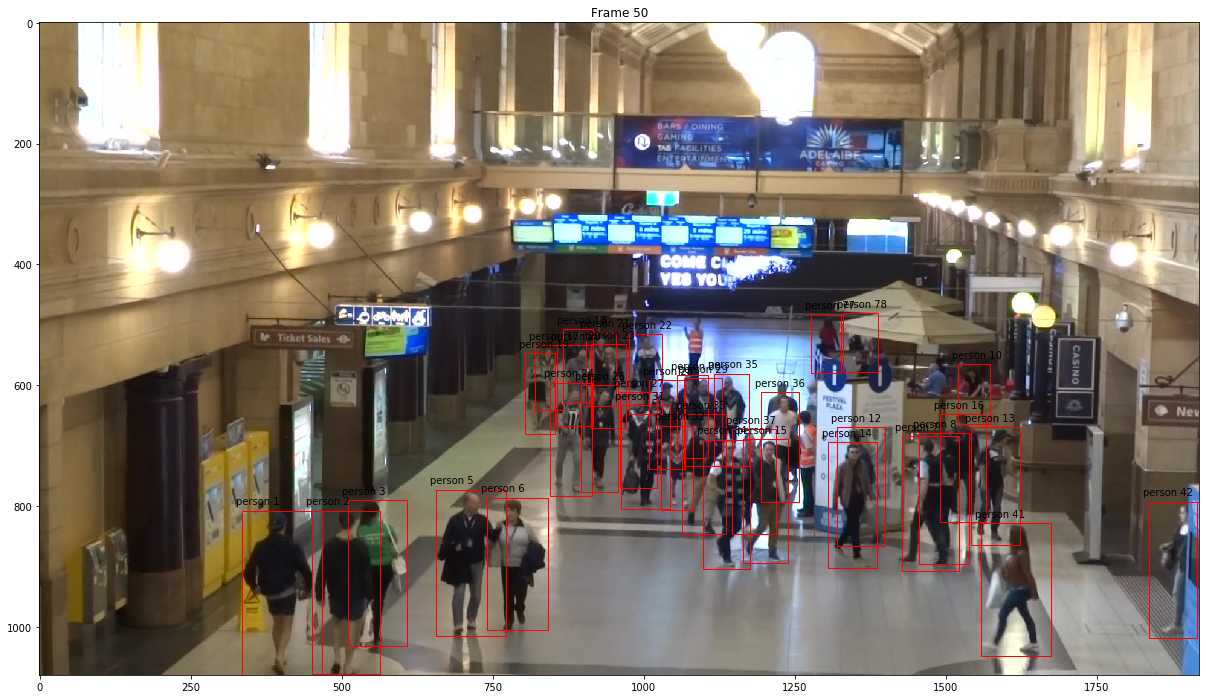

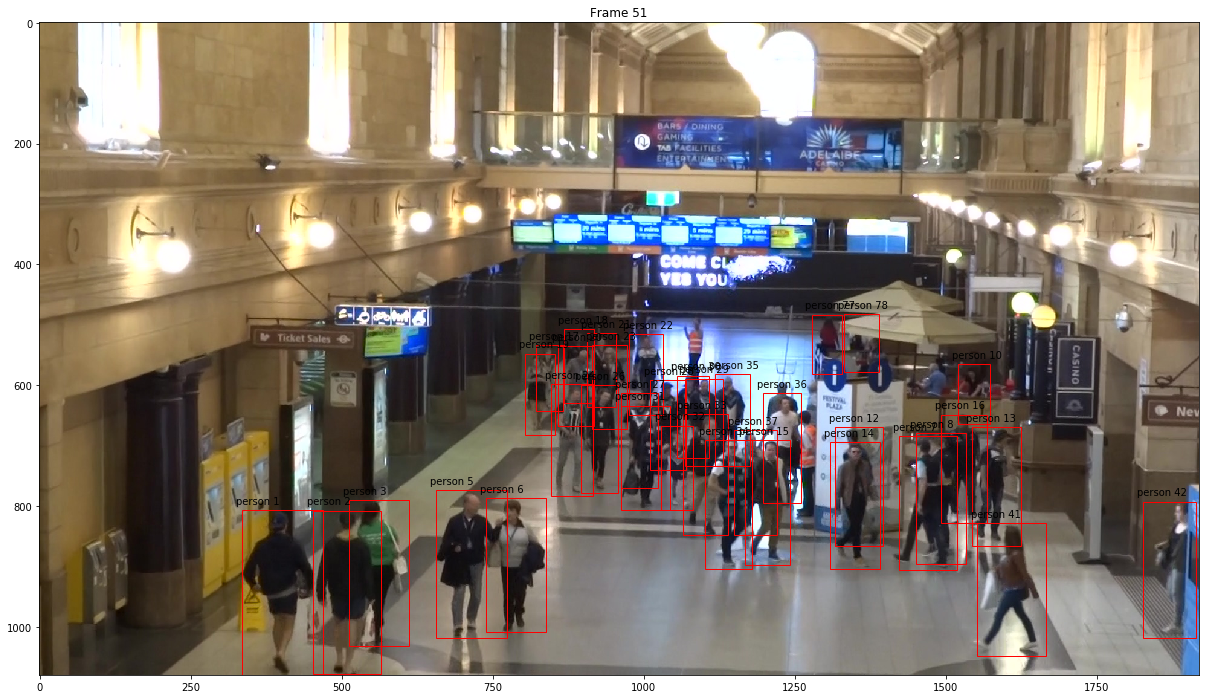

In [8]:
# plot our labels

start_ind = 50
for j in range(start_ind,start_ind+2): 

    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(24,12))
    ax.set_title(f'Frame {j}')

    # Display the image
    ax.imshow(imgs[j])

    for i,annot in enumerate(lab_dict[j]): 
        annot = np.array(annot, dtype=np.float32)
        # only show bboxes from pedestrian class
        if annot[6]==1:
            rect = patches.Rectangle((annot[2], annot[3]), annot[4], annot[5] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
            ax.add_patch(rect)
            plt.text(annot[2]-10, annot[3]-10, f"person {int(annot[1])}", fontdict=None) #

In [ ]:
# get our image paths 
img_path_dict = {}
img_paths = []
folders = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/*')
for fold in folders:
    img_path = glob(f"/home/ec2-user/SageMaker/MOT20/MOT20/train/{fold.split('/')[-1]}/img1/*")
    img_path.sort()
    img_paths.extend(img_path)
    img_path_dict[fold.split('/')[-1]] = img_path
    
# grab an example image from each video to use to capture image size
imgcheck = {}
for fold in img_path_dict:
    img = Image.open(img_path_dict[fold][0])
    imgcheck[fold] = img

In [49]:
for fold in imgcheck:
    print(imgcheck[fold].size)

1920
1654
1173
1920


May need to reorganize everything so that it's frame level 

annot[2] is X, annot[3] is y, annot[4] is width, annot[5] is height

Also need to restrict to pedestrian labels, which is in annot[6]

In [50]:
# put our data into CSV format 

# what I did for data prep

# loading all the images 

# grab image paths, can also do this using aws s3 if you don't have images stored locally
# helms = subprocess.check_output(['aws', 's3', 'ls', f's3://privisaa-bucket-virginia/nfl-data/helmet_imgs/']).decode('utf-8')
# helms = helms.split('\n')
# img_files = []
# for hel in helms:
#     img_files.append(hel.split(' ')[-1])


class_names = []
file_names = []
heights = []
widths = []
x_maxs = []
x_mins = []
y_maxs = []
y_mins = []
for vid in lab_txt_dict:
    for i,ann in enumerate(lab_txt_dict[vid]):
        for bbox in lab_txt_dict[vid][ann]: 
            # restrict to specifically pedestrians
            if int(bbox[6])==1:
                # in this case I had only one class, but you'll likely need to adjust for multi-class
                bbox = np.array(bbox, dtype=np.float32)
                class_names.append('pedestrian')
                # maek sure the paths you put in correspond to where the data will be in your container
                file_names.append(f"/opt/ml/input/data/train/{'/'.join(img_path_dict[vid][i].split('/')[-4:])}") # ann['dataObject']['s3Uri'].split('/')[4]
                heights.append(imgcheck[vid].size[1])
                widths.append(imgcheck[vid].size[0])
                x_maxs.append(int(bbox[2]+bbox[4]))
                x_mins.append(int(bbox[2]))
                y_maxs.append(int(bbox[3]))
                y_mins.append(int(bbox[3]+bbox[5]))
        
annot_df = pd.DataFrame()
annot_df['class_name'] = class_names
annot_df['file_name'] = file_names
annot_df['height'] = heights
annot_df['width'] = widths
annot_df['x_max'] = x_maxs
annot_df['x_min'] = x_mins
annot_df['y_max'] = y_maxs
annot_df['y_min'] = y_mins

annot_df.to_csv('sagemaker_mot20_annotations.csv')
annot_df.head()

# will also want to send this to s3 in same folder as images 

class_name                                          file_name  height  \
0  pedestrian  /opt/ml/input/data/train/train/MOT20-01/img1/0...    1080   
1  pedestrian  /opt/ml/input/data/train/train/MOT20-01/img1/0...    1080   
2  pedestrian  /opt/ml/input/data/train/train/MOT20-01/img1/0...    1080   
3  pedestrian  /opt/ml/input/data/train/train/MOT20-01/img1/0...    1080   
4  pedestrian  /opt/ml/input/data/train/train/MOT20-01/img1/0...    1080   

   width  x_max  x_min  y_max  y_min  
0   1920    339    199    813   1081  
1   1920    471    347    814   1081  
2   1920    503    399    789   1048  
3   1920   1751   1651    831   1081  
4   1920    764    667    686    907

In [51]:
!aws s3 cp sagemaker_mot20_annotations.csv s3://{bucket}/MOT20/sagemaker_mot20_annotations.csv

upload: ./sagemaker_mot20_annotations.csv to s3://privisaa-bucket-2/MOT20/sagemaker_mot20_annotations.csv


#!git clone https://github.com/facebookresearch/detectron2.git
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Had issues when launching the training job of it being able to import cityscapes evaluator 
need to specify your specific config file for training and also need to figure out how to handle the CSV piece, the location of the data is 
/opt/ml/input/data/train

In [75]:
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


Need to determine if you need a custom container for detectron2 or if you can just pass it to 
Eh you probably need a custom container. 
You can specify all of the dataset register stuff inside of train_net.py


In [52]:
%%sh

# The name of our algorithm
algorithm_name=detectron2-train-custom

chmod +x train
chmod +x serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

# some kind of security auth issue with pushing this to ecr, not authorized to perform ecr:InitiateLayerUpload
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  809.8MB
Step 1/18 : FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.5.1-gpu-py36-cu101-ubuntu16.04
 ---> bb5897d48beb
Step 2/18 : RUN pip install --upgrade --force-reinstall torch==1.5.1 torchvision==0.6.1 cython
 ---> Using cache
 ---> 5ba0f38390b5
Step 3/18 : RUN pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
 ---> Using cache
 ---> 4255cc06f8e6
Step 4/18 : RUN pip install 'git+https://github.com/facebookresearch/fvcore'
 ---> Using cache
 ---> c86fdb96c3ec
Step 5/18 : ENV FORCE_CUDA="1"
 ---> Using cache
 ---> ead802380997
Step 6/18 : ENV TORCH_CUDA_ARCH_LIST="Volta"
 ---> Using cache
 ---> f2c8f3ea9377
Step 7/18 : ENV FVCORE_CACHE="/tmp"
 ---> Using cache
 ---> f9ec6c4340fc
Step 8/18 : ENV DETECTRON2_DATASETS="/opt/ml/input/data/train"
 ---> Using cache
 ---> 321743f5539c
Step 9/18 : COPY plain_train_net.py /opt/ml/code/plain_train_net.py
 ---> e682dac33528
Step 10/18 :

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [53]:
s3train = f's3://{bucket}/MOT20/'

train = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type=None, s3_data_type='S3Prefix') 
# 'application/tfrecord'

data_channels = {'train': train}

data_channels['train'].config

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://privisaa-bucket-2/MOT20/',
   'S3DataDistributionType': 'FullyReplicated'}}}

In [39]:
metric_definitions=[{
        "Name": "total_loss",
        "Regex": ".*total_loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_cls",
        "Regex": ".*loss_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_box_reg",
        "Regex": ".*loss_box_reg:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_mask",
        "Regex": ".*loss_mask:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_cls",
        "Regex": ".*loss_rpn_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_loc",
        "Regex": ".*loss_rpn_loc:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "overall_training_speed",
        "Regex": ".*Overall training speed:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "lr",  
        "Regex": ".*lr:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "iter",  
        "Regex": ".*iter:\s([0-9\\.]+)\s*"
    }
]

In [54]:
# set our hyperparameters
account = boto3.client('sts').get_caller_identity()['Account']
image = f'{account}.dkr.ecr.us-east-1.amazonaws.com/detectron2-train-custom'
hyperparameters = {
                  'num_gpus':8,
                # below is a custom configuration file, be aware if you do choose to use a custom config file to utilize the
                # right backbone and base configurations
                  'config_file':'/opt/ml/code/detectron2/configs/quick_schedules/ped_mask_rcnn_R_50_FPN_training_acc_test.yaml'
#                 'train_batch_size':32, 
#                   'learning_rate':3e-5,
}

job_name = f'd2-custom-{time.time()}'

# instantiate model
torch_model = PyTorch( # job_name = job_name,
                        role=role,
                      train_instance_count=1,
                      train_instance_type= 'ml.p3dn.24xlarge', # try local
                      entry_point='plain_train_net.py',
                      image_name=image,
                      source_dir='/home/ec2-user/SageMaker/detectron2_train/',
                      framework_version='1.5.1',
                      hyperparameters=hyperparameters,
                      output_path=f"s3://{bucket}/d2_custom_job/",
                      metric_definitions = metric_definitions,
                     )


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


most recent training error 
FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_val2017.json'
#033[32m[07/11 20:54:10 d2.engine.defaults]: #033[0mModel:

need to create dataset json before creating container and send to 

In [55]:
torch_model.fit(inputs=data_channels, wait=False)

Can't seem to find the source directory you are uploading, it has to go somewhere. It seems like it should be going to /opt/ml/code but isn't making its way there... Maybe try a different path?